## Summary Statistics
---
Data cleaning and transformation

In [1]:
#load packages
import pandas as pd
import xlsxwriter
import matplotlib.pyplot as plt

In [2]:
#load data and convert dates to datetime
rw = pd.read_csv("..//Datasets/RW/RW_tail_numbers(cleaned).csv", encoding='latin-1', parse_dates=['dates'])

In [3]:
#inspect data
rw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140845 entries, 0 to 140844
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tail_number  140845 non-null  object        
 1   dates        140845 non-null  datetime64[ns]
 2   aircraft     133203 non-null  object        
 3   origin       140834 non-null  object        
 4   destination  140841 non-null  object        
 5   departure    140845 non-null  object        
 6   arrival      140676 non-null  object        
 7   duration     140641 non-null  object        
 8   NAME         140845 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 9.7+ MB


In [4]:
#glimpse to data 
rw.head()

,tail_number,dates,aircraft,origin,destination,departure,arrival,duration,NAME
0,N101AE,2021-02-07,B06,"Near Terre Haute, IN","Near Bloomington, IN",07:12AM EST,09:14AM EST,2:01,AIR EVAC EMS INC ...
1,N101AE,2021-02-05,B06,Cooper,"Near Indianapolis, IN",07:35PM EST,08:28PM EST,0:52,AIR EVAC EMS INC ...
2,N101AE,2021-02-05,B06,"Near Indianapolis, IN",Indianapolis Intl,01:02PM EST,01:08PM EST,0:05,AIR EVAC EMS INC ...
3,N101AE,2021-02-02,B06,"Near Indianapolis, IN",Marcidale,03:54PM EST,04:56PM EST,1:01,AIR EVAC EMS INC ...
4,N101AE,2021-01-23,B06,Frasca Fld,"Near ChampaignUrbana, IL",09:31PM CST,09:38PM CST,0:06,AIR EVAC EMS INC ...


In [5]:
#chech for null values
rw.isna().sum()

tail_number       0
dates             0
aircraft       7642
origin           11
destination       4
departure         0
arrival         169
duration        204
NAME              0
dtype: int64

In [6]:
#the null duration indicates that the flight was canceled or diverted. So, let's remove it 
rw = rw.dropna(subset=['duration'])

In [7]:
# convert duration to minutes and add a new column 
rw['duration_minutes'] = pd.to_datetime(rw.duration, format="%H:%M").dt.hour * 60 + pd.to_datetime(rw.duration, format="%H:%M").dt.minute

# convert duration to the H:M format
rw.duration = pd.to_datetime(rw.duration, format="%H:%M").dt.time

#rearrange data for the convenience
rw = rw.iloc[:,:8].join([rw.iloc[:,-1], rw.loc[:,'NAME']])

In [8]:
!!!# let's consider flights which more or equal 5 minutes. We don't think that flight that less than 5 minutes has any sense.
rw = rw.query("duration_minutes >= 5")
rw.head()

,tail_number,dates,aircraft,origin,destination,departure,arrival,duration,duration_minutes,NAME
0,N101AE,2021-02-07,B06,"Near Terre Haute, IN","Near Bloomington, IN",07:12AM EST,09:14AM EST,02:01:00,121,AIR EVAC EMS INC ...
1,N101AE,2021-02-05,B06,Cooper,"Near Indianapolis, IN",07:35PM EST,08:28PM EST,00:52:00,52,AIR EVAC EMS INC ...
2,N101AE,2021-02-05,B06,"Near Indianapolis, IN",Indianapolis Intl,01:02PM EST,01:08PM EST,00:05:00,5,AIR EVAC EMS INC ...
3,N101AE,2021-02-02,B06,"Near Indianapolis, IN",Marcidale,03:54PM EST,04:56PM EST,01:01:00,61,AIR EVAC EMS INC ...
4,N101AE,2021-01-23,B06,Frasca Fld,"Near ChampaignUrbana, IL",09:31PM CST,09:38PM CST,00:06:00,6,AIR EVAC EMS INC ...


### Summary statistics

In [9]:
# total number of flights by each service and its tail number 
total_flights = pd.DataFrame(rw.groupby("NAME").tail_number.value_counts()).rename({'tail_number':'Number of Flights'}, axis=1)

# Average Flights per Day
avg_total_flights = pd.Series(rw.groupby("NAME").tail_number.value_counts().sort_index() / rw.groupby(['NAME','tail_number']).dates.nunique(), name='Average Flights per Day')

In [10]:
stats = rw.groupby(["NAME", 'tail_number']).duration_minutes.agg(['sum','mean', 'median', 'max', 'min'])\
          .rename({'sum':'Total Duration(min)', 'mean':'Average Duration(min)', 'median':'Median Duration(min)', 'max':'MAX Duration(min)', 'min':'MIN Duration(min)'}, axis=1)

In [11]:
#total summary statistics 
total_stats = total_flights.join([avg_total_flights, stats])
total_stats.head()

Number of Flights  \
NAME                                               tail_number                      
AIR EVAC EMS INC                                   N652AE                     201   
                                                   N336AE                     195   
                                                   N96AE                      195   
                                                   N103AE                     184   
                                                   N395AE                     181   

                                                                Average Flights per Day  \
NAME                                               tail_number                            
AIR EVAC EMS INC                                   N652AE                      3.092308   
                                                   N336AE                      2.635135   
                                                   N96AE                       3.000000   
                                                   N103AE                      2.666667   
                                                   N395AE                      2.623188   

                                                                Total Duration(min)  \
NAME                                               tail_number                        
AIR EVAC EMS INC                                   N652AE                      8684   
                                                   N336AE                     13812   
                                                   N96AE                       7791   
                                                   N103AE                     11640   
                                                   N395AE                     12087   

                                                                Average Duration(min)  \
NAME                                               tail_number                          
AIR EVAC EMS INC                                   N652AE                   43.203980   
                                                   N336AE                   70.830769   
                                                   N96AE                    39.953846   
                                                   N103AE                   63.260870   
                                                   N395AE                   66.779006   

                                                                Median Duration(min)  \
NAME                                               tail_number                         
AIR EVAC EMS INC                                   N652AE                       17.0   
                                                   N336AE                       72.0   
                                                   N96AE                        26.0   
                                                   N103AE                       58.5   
                                                   N395AE                       52.0   

                                                                MAX Duration(min)  \
NAME                                               tail_number                      
AIR EVAC EMS INC                                   N652AE                     296   
                                                   N336AE                     313   
                                                   N96AE                      216   
                                                   N103AE                     276   
                                                   N395AE                     349   

                                                                MIN Duration(min)  
NAME                                               tail_number                     
AIR EVAC EMS INC                                   N652AE                       5  
                                                   N336AE                       5  
                                               

In [12]:
# Origins (where does the flight start each time)
Origins = pd.DataFrame(rw.groupby(['NAME', 'tail_number']).origin.value_counts()).rename({'origin':'Number of Flights'}, axis=1)
Origins.head()

Number of Flights
NAME                                               tail_number origin                                  
AIR EVAC EMS INC                                   N101AE      Near Indianapolis, IN                 13
                                                               Near Terre Haute, IN                   7
                                                               Near Sullivan, IN                      6
                                                               Cooper                                 2
                                                               Near Greencastle, IN                   2

In [13]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('..//Datasets/RW/RW_stats.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
total_stats.to_excel(writer, sheet_name='stats')
Origins.to_excel(writer, sheet_name='origin')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

## Time Series Analysis
---
Data cleaning and transformation

In [14]:
# split time zone and assign to new variable for arrival
rw['arr_time_zone'] = rw.arrival.str.split(" ", n = 1, expand = True)[1]

# remove time zome from arrival
rw.arrival = rw.arrival.str.split(" ", n = 1, expand = True)[0]

# rearrange data for the convenience 
rw = rw.iloc[:,:7].join([rw.iloc[:,-1], rw.iloc[:,7:10]])

In [15]:
# split time zone and assign to new variable for departure
rw['dep_time_zone'] = rw.departure.str.split(" ", n = 1, expand = True)[1]

# remove time zome from departure
rw.departure = rw.departure.str.split(" ", n = 1, expand = True)[0]

# rearrange data for the convenience 
rw = rw.iloc[:,:6].join([rw.iloc[:,-1], rw.iloc[:,6:11]])

In [16]:
# convert departure time to the 24-format 
# rw.departure = pd.to_datetime(rw.departure).dt.strftime('%H:%M')

# convert arrival time to the 24-format 
# rw.arrival = pd.to_datetime(rw.arrival, errors='coerce').dt.strftime('%H:%M')

In [17]:
# drop all unconverted records
rw = rw.dropna(subset=['arrival'])

In [18]:
# Let's figure out the date range of our dataset with which we will deal
print("From", rw.dates.dt.date.min(), "to", rw.dates.dt.date.max())

From 2020-10-30 to 2021-02-13


### Tables and graphs

In [19]:
# total number of flight by day
daily_flights = pd.DataFrame(rw.dates.value_counts()).sort_index()
daily_flights.head()

,dates
2020-10-30,483
2020-10-31,1784
2020-11-01,1430
2020-11-02,1588
2020-11-03,1748


In [20]:
# As we don't have access to the data for the entire October and February,
# we have to exclude the first and the last days of these months in our date range. 
# Otherwise, it may give wrong outcomes
daily_flights = daily_flights.loc['2020-10-31':'2021-2-12'].rename({'dates':'number of flights'}, axis=1)

# Add a moving Average for 30 days window to see trend
daily_flights['Moving average for 30 days window'] = daily_flights['number of flights'].rolling(window='30D').mean()

In [21]:
# add Covid19 cases to observe correlation. Source: https://covidtracking.com/data/download
covid19 = pd.read_csv('..//Datasets/national-history.csv', parse_dates=['date'], index_col='date')
covid19 = covid19.positiveIncrease.loc['2021-2-12':'2020-10-31']

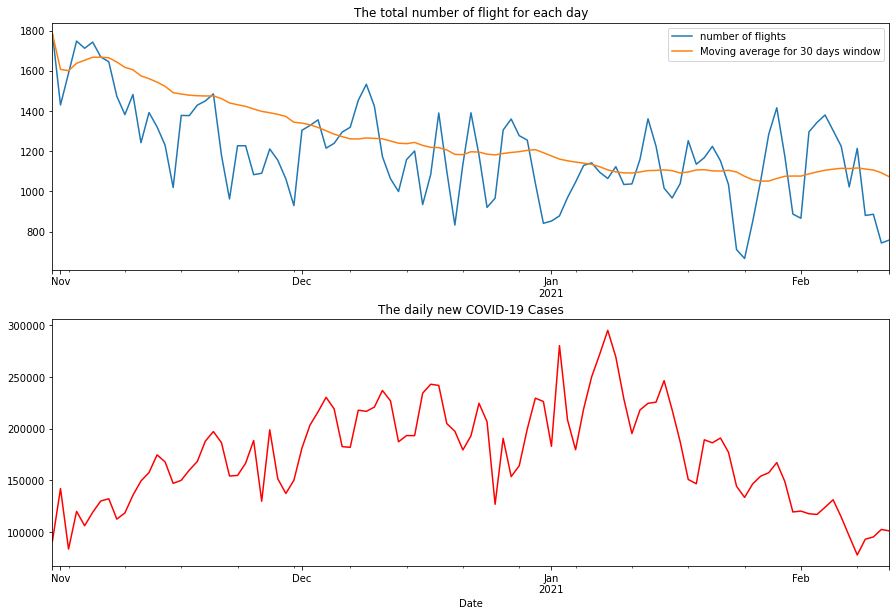

In [22]:
# Let's visualize the number of flight for each day

fig, ax = plt.subplots(2)
fig.set_size_inches(15, 10)
daily_flights.plot(ax=ax[0])
ax[0].set_title("The total number of flight for each day")
covid19.plot(ax=ax[1], color='red')
ax[1].set_title("The daily new COVID-19 Cases")
plt.xlabel("Date")
plt.show()

In [24]:
# create new variable of flight duration for each day from 2020-10-31
duration = rw.set_index("dates").duration_minutes.sort_index().iloc[2020-10-31:]

In [25]:
# calculate average suration for each day
avg_duration = duration.groupby('dates').mean()
avg_duration['rolling average for 30 days window'] = avg_duration['number of flights'].rolling(window='30D').mean()

KeyError: 'number of flights'

In [ ]:
avg_duration.head(20)

NameError: name 'avg_duration' is not defined

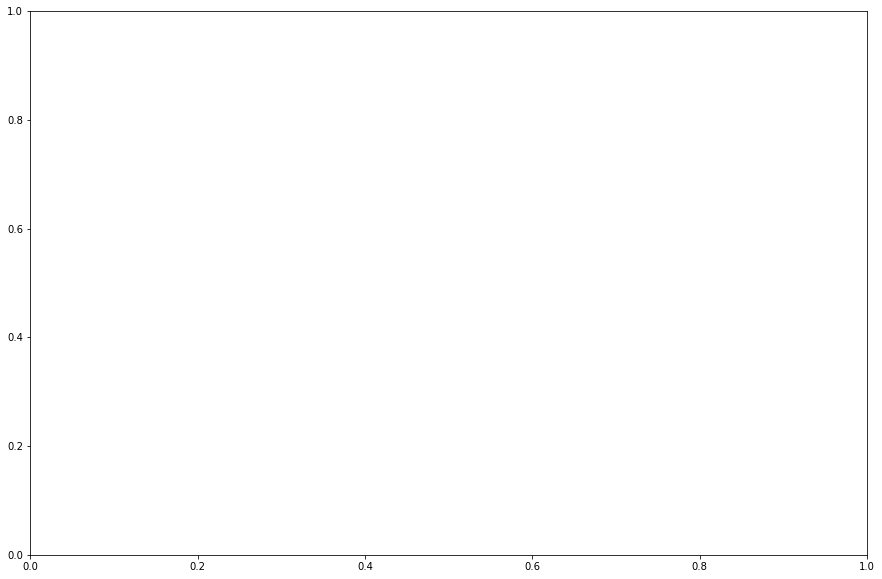

In [44]:
# Let's visualize the average duration
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
avg_duration.plot(ax=ax)
plt.title("Average flight duration in minutes")
plt.xlabel("Date")
plt.show()